In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split

In [2]:
def define_pandas_options():
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.max_colwidth', None)
    pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [3]:
def string_to_vector(s):
    try:
        s = s.split('[')[1].split(']')[0]
        x = float(s.split()[0])
        y = float(s.split()[1])
        return np.array([x, y])
    except AttributeError:
        return None

def get_position_delta(row):
    return row.s / 10 * row.dir_vec

def get_relative_position(row):
    if row.frameId == 1:
        return np.array([0, 0])
    else:
        last_pos = row.shift(1).rel_pos
        return last_pos + row.pos_delta

In [4]:
pl_cols = ['gameId', 'playId', 'offense_h_play', 'offense_h_presnap', 'offense_h_to_throw', 'offense_h_to_arrived', 'offense_h_to_end', 'defense_h_play', 'defense_h_presnap', 'defense_h_to_throw', 'defense_h_to_arrived', 'defense_h_to_end', 'offense_p_play', 'offense_p_presnap', 'offense_p_to_throw', 'offense_p_to_arrived', 'offense_p_to_end', 'offense_m_play', 'offense_m_presnap', 'offense_m_to_throw', 'offense_m_to_arrived', 'offense_m_to_end', 'offense_v_play', 'offense_v_presnap', 'offense_v_to_throw', 'offense_v_to_arrived', 'offense_v_to_end', 'offense_a_play', 'offense_a_presnap', 'offense_a_to_throw', 'offense_a_to_arrived','offense_a_to_end', 'defense_p_play', 'defense_p_presnap','defense_p_to_throw', 'defense_p_to_arrived', 'defense_p_to_end','defense_m_play', 'defense_m_presnap', 'defense_m_to_throw','defense_m_to_arrived', 'defense_m_to_end', 'defense_v_play', 'defense_v_presnap', 'defense_v_to_throw', 'defense_v_to_arrived','defense_v_to_end', 'defense_a_play', 'defense_a_presnap','defense_a_to_throw', 'defense_a_to_arrived', 'defense_a_to_end','HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER', 'IN', 'ANGLE', 'POST', 'WHEEL']

play_df = pd.read_csv('d20_intermediate_files/play_results.csv', usecols=pl_cols)
play_df['num_routes'] = play_df[['HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER', 'IN', 'ANGLE', 'POST', 'WHEEL']].T.sum()
play_df.drop(play_df[play_df['num_routes'] == 0].index, inplace=True)
play_df.dropna(inplace=True)

fr_cols = ['gameId', 'playId', 'frameId', 'offense_p_group', 'defense_p_group', 'offense_m_group', 'defense_m_group', 'o_state', 'd_state', 'offense_v_group', 'defense_v_group', 'offense_a_group', 'defense_a_group', 'a_group_ratio']
frame_df = pd.read_csv('d20_intermediate_files/frame_results.csv', usecols=fr_cols)

tr_cols = ['time', 's', 'a', 'dis', 'event', 'nflId', 'displayName', 'jerseyNumber', 'position', 'frameId', 'team', 'gameId', 'playId', 'playDirection', 'route', 'pos', 'teamType', 'o_vec', 'dir_vec', 'r_vec']
tracking_df = pd.read_csv('d20_intermediate_files/tracking_results.csv', usecols=tr_cols, chunksize=1000000)

In [204]:
#tracking_df['pos'] = tracking_df['pos'].apply(string_to_vector)
#tracking_df['o_vec'] = tracking_df['o_vec'].apply(string_to_vector)
#tracking_df['dir_vec'] = tracking_df['dir_vec'].apply(string_to_vector)
#tracking_df['r_vec'] = tracking_df['r_vec'].apply(string_to_vector)

In [205]:
#tracking_df['gpid'] = tracking_df.apply(lambda x: str(x.gameId) + '-' + str(x.playId), axis=1)

In [206]:
runners = tracking_df.loc[(tracking_df['position'].isin(['QB', 'WR', 'RB', 'TE']))].copy()
del tracking_df

In [207]:
runners['pos'] = runners['pos'].apply(string_to_vector)
runners['o_vec'] = runners['o_vec'].apply(string_to_vector)
runners['dir_vec'] = runners['dir_vec'].apply(string_to_vector)
runners['r_vec'] = runners['r_vec'].apply(string_to_vector)
runners['gpid'] = runners.apply(lambda x: str(x.gameId) + '-' + str(x.playId), axis=1)

In [208]:
qb_positions = runners.loc[(runners['frameId'] == 1) & (runners['position'] == 'QB')][['gpid', 'pos']].copy()

In [209]:
runners = runners.loc[(~runners['route'].isna())]

In [210]:
# Convert nan forced floats to ints and NA
runners['nflId'] = runners['nflId'].astype('Int64')
runners['jerseyNumber'] = runners['jerseyNumber'].astype('Int64')

In [211]:
gpids = runners['gpid'].unique().tolist()

In [214]:
routes_df = pd.DataFrame(columns=['gpid', 'nflId', 'route', 'pos'])
index = 0
end_events = ['pass_arrived', 'pass_outcome_caught', 'out_of_bounds',
                       'pass_outcome_incomplete', 'first_contact', 'tackle', 'man_in_motion', 'play_action', 'handoff',
                       'pass_tipped', 'pass_outcome_interception', 'pass_shovel', 'line_set', 'pass_outcome_touchdown',
                       'fumble', 'fumble_offense_recovered', 'fumble_defense_recovered', 'touchdown', 'shift',
                       'touchback', 'penalty_flag', 'penalty_accepted', 'field_goal_blocked']

# Generate vectors of positions
for gpid in gpids[:1000]:
    df = runners.loc[runners['gpid'] == gpid]
    players = df['nflId'].unique().tolist()
    centre_pos = qb_positions.loc[(qb_positions['gpid'] == gpid)]['pos'].values[0][1]
    for player in players:
        player_df = df.loc[(df['nflId'] == player)]
        if player > 0:
            start_frame = player_df.loc[player_df['event'] == 'ball_snap']['frameId'].min()
            end_frame = player_df.loc[player_df['event'].isin(end_events)]['frameId'].min()
            if end_frame > start_frame:
                positions = []
                start_pos = player_df.loc[(player_df['frameId'] == start_frame)]['pos'].values[0]
                flip_arr = True if start_pos[1] < centre_pos else False
                for frame in range(start_frame + 1, end_frame + 1):
                    # positions.append(player_df.loc[(player_df['frameId'] == frame)]['pos'].values[0].tolist())
                    new_pos = player_df.loc[(player_df['frameId'] == frame)]['pos'].values[0].tolist()
                    if flip_arr: new_pos[1] = new_pos[1] * -1
                    new_pos.append(player_df.loc[(player_df['frameId'] == frame)]['s'].values[0])
                    positions.append(new_pos)
                positions = np.array(positions)
                try:
                    routes_df.loc[index] = {
                        'gpid': str(gpid),
                        'nflId': int(player),
                        'route': str(player_df.loc[(player_df['frameId'] == 1)]['route'].values[0]),
                        'pos': positions - positions[0]
                    }
                    index += 1
                except IndexError:
                    print(f'Data error for gpid {gpid}, player {player} (Start {start_frame} | End {end_frame})')

del runners

In [84]:
# Convert position sequences to 2d array with np.histogram2d

In [85]:
# Convert 2d array to 1d array

(-40.0, 40.0)

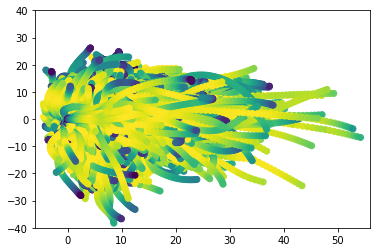

In [215]:
x = [0, 0]
y = [0, 0]

for idx, row in routes_df.iterrows():
    if row['pos'][:, 0].min() < x[0]: x[0] = row['pos'][:, 0].min()
    if row['pos'][:, 0].max() > x[1]: x[1] = row['pos'][:, 0].max()
    if row['pos'][:, 1].min() < y[0]: y[0] = row['pos'][:, 1].min()
    if row['pos'][:, 1].max() > y[1]: y[1] = row['pos'][:, 1].max()
    plt.scatter(row['pos'][:, 0], row['pos'][:, 1], c=row['pos'][:, 2])
x = [np.floor(x[0]), np.ceil(x[1])]
plt.xlim(x[0] - 1, x[1] + 1)
y[0] = -1 * np.ceil(max(abs(y[0]), abs(y[1])))
y[1] = abs(y[0])
plt.ylim(y[0] - 1, y[1] + 1)

In [216]:
x_dim = int(abs(x[0]) + abs(x[1]))
y_dim = int(abs(y[0]) + abs(y[1]))

In [217]:
grid = np.zeros(x_dim * y_dim).reshape(x_dim, y_dim)

In [218]:
grids = []
for idx, row in routes_df.iterrows():
    grid = np.zeros(x_dim * y_dim).reshape(x_dim, y_dim)
    for position in row['pos']:
        grid[int(position[0]), int(position[1])] = position[2]
    grids.append(grid.reshape(x_dim * y_dim))

In [219]:
routes_df['grid'] = grids
#routes_df.drop(['pos'], axis=1, inplace=True)

In [91]:
# flatten the images
n_samples = len(grids)

# Create a classifier: a support vector classifier
clf = svm.SVC(gamma=0.005, kernel='rbf')

# Split data into 50% train and 50% test subsets
x_train, x_test, y_train, y_test = train_test_split(grids, routes_df['route'], test_size=0.6, shuffle=False, random_state=1)

# Learn the digits on the train subset
clf.fit(x_train, y_train)

# Predict the value of the digit on the test subset
predicted = clf.predict(x_test)

In [92]:
print(
    f'Classification report for classifier {clf}:\n'
    f'{metrics.classification_report(y_test, predicted)}\n'
)

Classification report for classifier SVC(gamma=0.005):
              precision    recall  f1-score   support

       ANGLE       1.00      0.12      0.21        25
      CORNER       0.00      0.00      0.00        22
       CROSS       0.38      0.06      0.11        49
        FLAT       0.51      0.75      0.61        71
          GO       0.38      0.68      0.48       117
       HITCH       0.45      0.71      0.55       111
          IN       0.17      0.05      0.08        39
         OUT       0.57      0.31      0.40        55
        POST       0.00      0.00      0.00        30
      SCREEN       0.35      0.30      0.32        30
       SLANT       0.45      0.28      0.34        36
   undefined       0.00      0.00      0.00         4

    accuracy                           0.43       589
   macro avg       0.35      0.27      0.26       589
weighted avg       0.40      0.43      0.37       589




/Users/spencer/PycharmProjects/cosc301/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/spencer/PycharmProjects/cosc301/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/spencer/PycharmProjects/cosc301/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Confusion Matrix:
[[ 3  0  0  9  5  6  0  0  0  2  0  0]
 [ 0  0  0  0 16  6  0  0  0  0  0  0]
 [ 0  0  3  9 21 14  0  0  0  2  0  0]
 [ 0  0  2 53  9  2  0  2  0  3  0  0]
 [ 0  0  0  5 79 20  3  5  0  5  0  0]
 [ 0  0  1  4 12 79  4  3  0  0  8  0]
 [ 0  0  0  0 16 14  2  2  0  2  3  0]
 [ 0  0  1  6 21  8  0 17  0  1  1  0]
 [ 0  0  0  0 24  5  1  0  0  0  0  0]
 [ 0  0  1 16  1  3  0  0  0  9  0  0]
 [ 0  0  0  1  6 15  2  0  0  2 10  0]
 [ 0  0  0  1  0  2  0  1  0  0  0  0]]


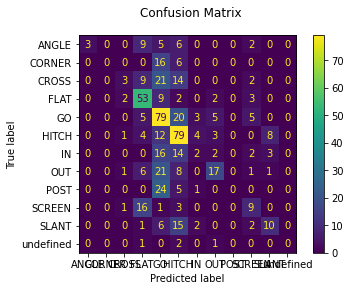

In [93]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted)
disp.figure_.suptitle('Confusion Matrix')
print(f'Confusion Matrix:\n{disp.confusion_matrix}')
plt.show()

In [94]:
routes_df['route'].value_counts().sum()

981

<BarContainer object of 13 artists>

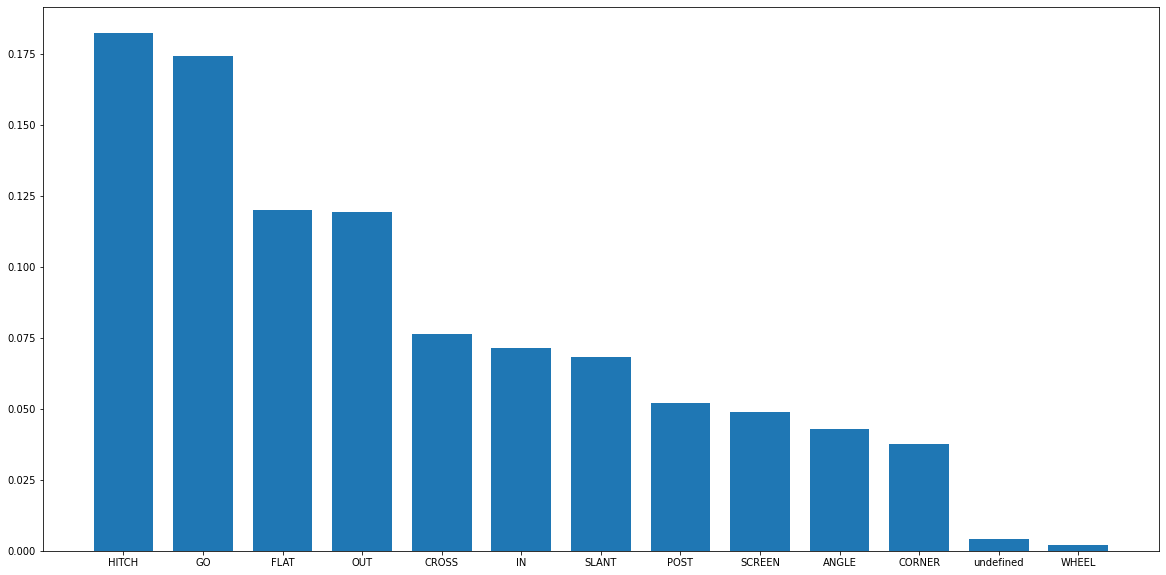

In [95]:
plt.figure(figsize=(20,10))
plt.bar(routes_df['route'].value_counts().index, routes_df['route'].value_counts().values / routes_df['route'].value_counts().sum(), width=0.75)

In [96]:
routes_df['route'].count()

981

In [97]:
routes_df.loc[routes_df['route'] == 'WHEEL']['route'].count()

2

In [98]:
7142/39645

0.1801488207844621

In [99]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

In [100]:
scaler = StandardScaler()

scaler.fit(x_train)
x_train2 = scaler.transform(x_train)
x_test2 = scaler.transform(x_test)

In [101]:
clf2 = MLPClassifier(solver='lbfgs', random_state=1, max_iter=1000)
clf2.fit(x_train2, y_train)

MLPClassifier(max_iter=1000, random_state=1, solver='lbfgs')

In [192]:
predicted2 = clf2.predict(x_test2)

In [103]:
print(
    f'Classification report for classifier {clf2}:\n'
    f'{metrics.classification_report(y_test, predicted2)}\n'
)

Classification report for classifier MLPClassifier(max_iter=1000, random_state=1, solver='lbfgs'):
              precision    recall  f1-score   support

       ANGLE       0.36      0.36      0.36        25
      CORNER       0.05      0.05      0.05        22
       CROSS       0.36      0.16      0.23        49
        FLAT       0.61      0.72      0.66        71
          GO       0.36      0.30      0.33       117
       HITCH       0.33      0.39      0.35       111
          IN       0.16      0.28      0.20        39
         OUT       0.29      0.27      0.28        55
        POST       0.20      0.20      0.20        30
      SCREEN       0.39      0.23      0.29        30
       SLANT       0.19      0.22      0.21        36
   undefined       0.00      0.00      0.00         4

    accuracy                           0.33       589
   macro avg       0.28      0.27      0.26       589
weighted avg       0.33      0.33      0.32       589




/Users/spencer/PycharmProjects/cosc301/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/spencer/PycharmProjects/cosc301/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/spencer/PycharmProjects/cosc301/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Confusion Matrix:
[[ 9  0  1  3  3  4  0  2  1  1  1  0]
 [ 0  1  0  0  5  5  8  1  2  0  0  0]
 [ 0  1  8  4  3 10  5  3  1  4 10  0]
 [ 5  0  4 51  1  0  0  4  0  6  0  0]
 [ 2  9  0  5 35 28 10 17  9  0  2  0]
 [ 2  2  4  3 21 43 10  4  6  0 16  0]
 [ 1  1  0  1  5 13 11  0  3  0  4  0]
 [ 2  2  2  6 15  6  5 15  2  0  0  0]
 [ 0  3  0  0  5  7  8  1  6  0  0  0]
 [ 3  0  2  9  2  2  1  3  0  7  1  0]
 [ 1  0  1  1  1 12 11  1  0  0  8  0]
 [ 0  0  0  1  0  2  0  1  0  0  0  0]]


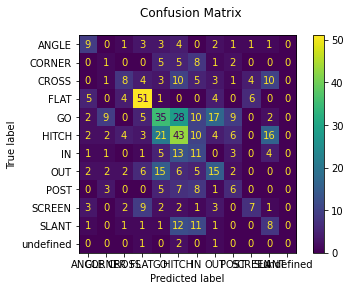

In [104]:
disp2 = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted2)
disp2.figure_.suptitle('Confusion Matrix')
print(f'Confusion Matrix:\n{disp2.confusion_matrix}')
plt.show()

In [105]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()

In [106]:
model.fit(x_train2, y_train)

RandomForestClassifier()

In [107]:
y_pred = model.predict(x_test2)

In [108]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

In [109]:
accuracy_score(y_pred, y_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

       ANGLE       0.36      0.36      0.36        25
      CORNER       0.00      0.00      0.00         4
       CROSS       0.33      0.44      0.38        36
        FLAT       0.73      0.52      0.61       100
          GO       0.56      0.50      0.53       132
       HITCH       0.59      0.52      0.55       128
          IN       0.10      0.14      0.12        29
         OUT       0.31      0.39      0.34        44
        POST       0.30      0.35      0.32        26
      SCREEN       0.27      0.50      0.35        16
       SLANT       0.44      0.33      0.38        48
       WHEEL       0.00      0.00      0.00         1
   undefined       0.00      0.00      0.00         0

    accuracy                           0.45       589
   macro avg       0.31      0.31      0.30       589
weighted avg       0.50      0.45      0.47       589



/Users/spencer/PycharmProjects/cosc301/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/spencer/PycharmProjects/cosc301/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/spencer/PycharmProjects/cosc301/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

In [110]:
confusion_matrix(y_pred, y_test)

array([[ 9,  0,  1,  5,  1,  4,  0,  3,  0,  1,  1,  0,  0],
       [ 0,  0,  2,  0,  1,  0,  0,  0,  1,  0,  0,  0,  0],
       [ 1,  1, 16,  4,  3,  5,  0,  1,  0,  3,  2,  0,  0],
       [ 4,  0, 10, 52,  9,  4,  1,  6,  0, 11,  2,  0,  1],
       [ 2,  9,  3,  2, 66,  6,  7, 17, 14,  2,  3,  0,  1],
       [ 2,  4,  9,  1, 11, 66, 15,  6,  3,  2,  9,  0,  0],
       [ 1,  2,  1,  0,  5,  9,  4,  1,  2,  1,  3,  0,  0],
       [ 2,  1,  1,  3, 11,  5,  2, 17,  0,  1,  0,  0,  1],
       [ 0,  4,  1,  0,  6,  1,  3,  2,  9,  0,  0,  0,  0],
       [ 1,  0,  2,  4,  0,  0,  0,  1,  0,  8,  0,  0,  0],
       [ 3,  1,  3,  0,  3, 11,  7,  1,  1,  1, 16,  0,  1],
       [ 0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])

In [ ]:
classes = {}
index = 0
for route in routes_df['route'].unique().tolist():
    classes[index] = route
    index += 1
classes

In [ ]:
route_idx = {}
for idx, value in classes.items():
    route_idx[value] = idx
route_idx

In [ ]:
routes_df['route_int'] = routes_df['route'].apply(lambda x: route_idx[x])
routes_df.head()

In [ ]:
import torch
from torch import nn

# Create device agnostic code
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
device

In [ ]:
class MultiClassModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=0):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features),
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/ len(y_pred)) * 100
    return acc

mc_model = MultiClassModel(input_features=x_dim*y_dim, output_features=len(classes), hidden_units=1024).to(device)

loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(mc_model.parameters(), lr=1)

In [ ]:
# Split data into 50% train and 50% test subsets
x_train, x_test, y_train, y_test = train_test_split(grids, routes_df['route_int'], test_size=0.2, shuffle=False, random_state=1)

torch.manual_seed(42)
epochs = 500

x_train, y_train = torch.as_tensor(x_train).float().to(device), torch.as_tensor(y_train.to_numpy()).to(device)
x_test, y_test = torch.as_tensor(x_test).float().to(device), torch.as_tensor(y_test.to_numpy()).to(device)

for epoch in range(epochs):
    ### Training
    mc_model.train()

    # 1. Forward Pass
    y_logits = mc_model(x_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    # 2. Calculate loss and energy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # 3. Optimiser zero grad (clear gradients)
    optimiser.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimiser step
    optimiser.step()

    ### Testing
    mc_model.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = mc_model(x_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

In [ ]:
mc_model.eval()
with torch.inference_mode():
    y_logits = mc_model(x_test)

y_pred_probs = torch.softmax(y_logits, dim=1)
y_preds = y_pred_probs.argmax(dim=1)

#print(f'Predictions: {y_preds}\nLabels: {y_test}')
print(f'Test accuracy: {accuracy_fn(y_true=y_test, y_pred=y_preds):.2f}%')

In [ ]:
print(
    f'Classification report for classifier {mc_model}:\n'
    f'{metrics.classification_report(y_test.cpu(), y_preds.cpu())}\n'
)

In [ ]:
disp2 = metrics.ConfusionMatrixDisplay.from_predictions(y_test.cpu(), y_preds.cpu())
disp2.figure_.suptitle('Confusion Matrix')
print(f'Confusion Matrix:\n{disp2.confusion_matrix}')
plt.xlabel(classes)
plt.show()